# UK - FINAL MODEL

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
import re
from math import sqrt
import os
import warnings
import datetime

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

E:\Ananconda_Installation\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Ananconda_Installation\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
E:\Ananconda_Installation\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 1. Reading Data

In [2]:
df_unemployment=pd.read_csv(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\oecd\Unemployment_Rate_OECD.csv')
df_unemployment.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HUR,TOT,PC_LF,A,1967,1.875,NaN
1,AUS,HUR,TOT,PC_LF,A,1968,1.850,NaN
2,AUS,HUR,TOT,PC_LF,A,1969,1.800,NaN
3,AUS,HUR,TOT,PC_LF,A,1970,1.625,NaN
4,AUS,HUR,TOT,PC_LF,A,1971,1.925,NaN


In [3]:
df_unemployment['LOCATION'].unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN', 'FRA', 'DEU',
       'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX',
       'NLD', 'NZL', 'NOR', 'POL', 'PRT', 'SVK', 'ESP', 'SWE', 'CHE',
       'TUR', 'GBR', 'USA', 'CHL', 'EST', 'ISR', 'SVN', 'OECD', 'G-7',
       'EA19', 'LVA', 'LTU', 'COL', 'EU27_2020', 'CRI'], dtype=object)

In [4]:
#Location variable to control country
location='GBR'

In [5]:
df_unemployment=df_unemployment[(df_unemployment['LOCATION']==location)&(df_unemployment['SUBJECT']=='TOT')].copy()
df_unemployment_monthly=df_unemployment[df_unemployment['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]
df_unemployment_monthly['TIME']=pd.to_datetime(df_unemployment_monthly['TIME'],format='%Y-%m')
df_unemployment_monthly=df_unemployment_monthly.set_index('TIME')

C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_4152\495960325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unemployment_monthly['TIME']=pd.to_datetime(df_unemployment_monthly['TIME'],format='%Y-%m')


In [6]:
df_unemployment_monthly

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,Value,Flag Codes
TIME,,,,,,,
1983-01-01,GBR,HUR,TOT,PC_LF,M,10.7,NaN
1983-02-01,GBR,HUR,TOT,PC_LF,M,10.8,NaN
1983-03-01,GBR,HUR,TOT,PC_LF,M,10.8,NaN
1983-04-01,GBR,HUR,TOT,PC_LF,M,11.0,NaN
1983-05-01,GBR,HUR,TOT,PC_LF,M,10.9,NaN
...,...,...,...,...,...,...,...
2022-08-01,GBR,HUR,TOT,PC_LF,M,3.6,NaN
2022-09-01,GBR,HUR,TOT,PC_LF,M,3.7,NaN
2022-10-01,GBR,HUR,TOT,PC_LF,M,3.7,NaN


## 2. Univariate Time Series ARIMA

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

### 2.1. EDA

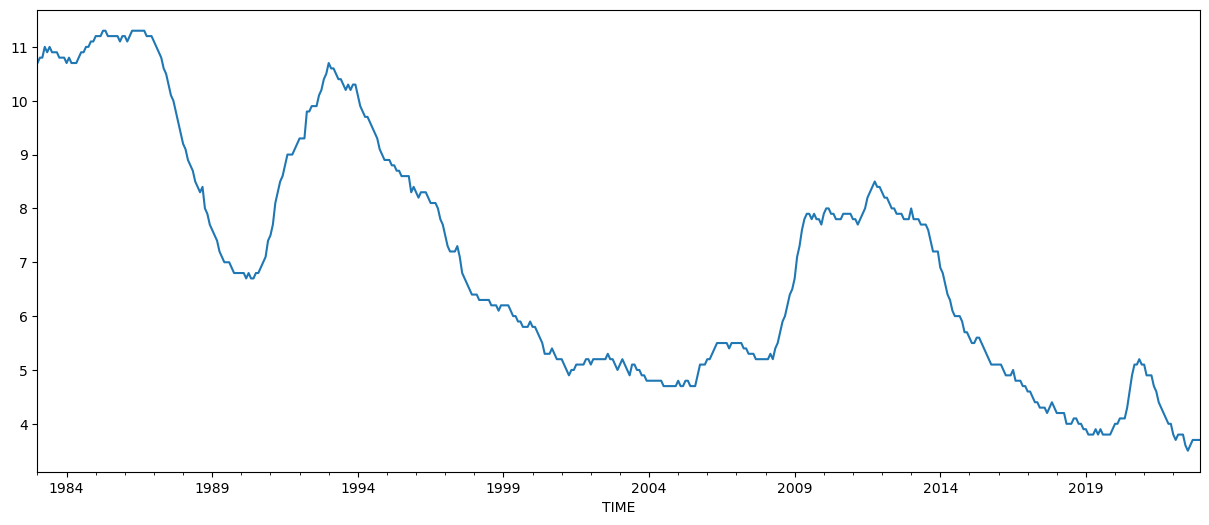

In [7]:
df_unemployment_monthly['Value'].plot(figsize=(15, 6))
plt.show()

#### 2.1.1. Decomposing Time Series to Trend, Seasonality and Residuals

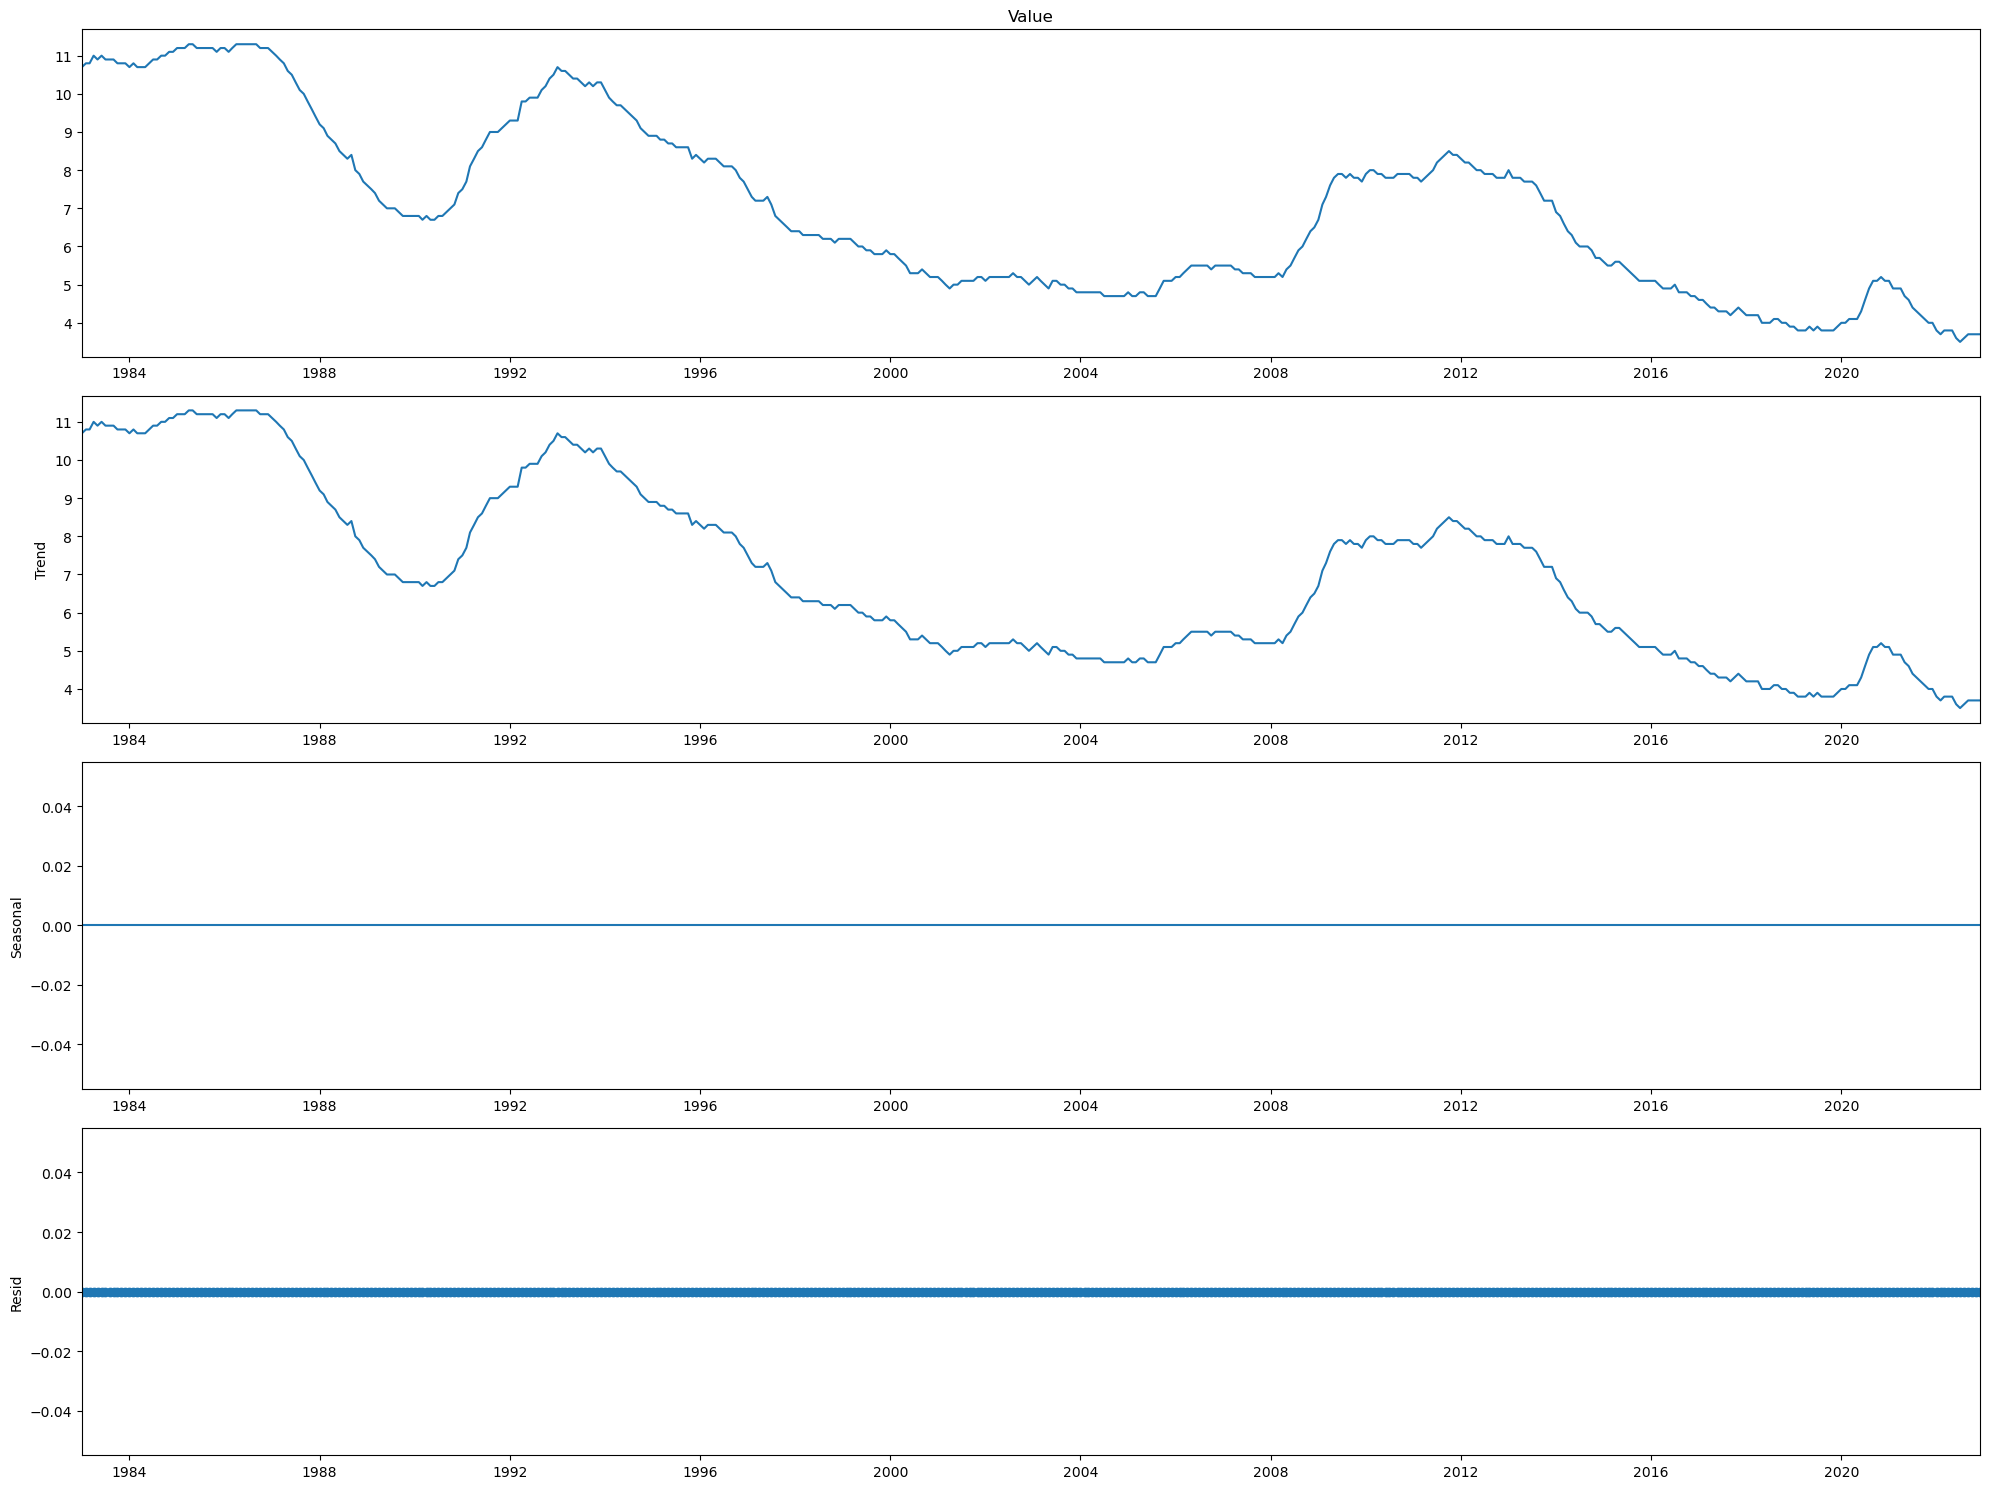

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15
decomposition = sm.tsa.seasonal_decompose(df_unemployment_monthly['Value'], model='additive',period=1)
fig = decomposition.plot()
plt.show()

#### 2.1.2. Checking Stationarity

In [9]:
adfuller_result = adfuller(df_unemployment_monthly['Value'].values, autolag='AIC')
print('ADF statistics: ', adfuller_result[0])
print('p-value: ', adfuller_result[1])
if adfuller_result[1] >= 0.05:
    print('------Non-stationary time series. Checking first difference------------')
    df_unemployment_monthly_transformed = df_unemployment_monthly['Value'].diff().dropna()
    adfuller_result = adfuller(df_unemployment_monthly_transformed.values, autolag='AIC')
    print('ADF statistics at first difference: ', adfuller_result[0])
    print('p-value: ', adfuller_result[1])
else:
    print('Stationary time series')

ADF statistics:  -2.168487177995217
p-value:  0.21788089530330884
------Non-stationary time series. Checking first difference------------
ADF statistics at first difference:  -4.188713460652136
p-value:  0.0006884934006564331


### 2.2. Modelling 

In [10]:
train_limit=df_unemployment_monthly.shape[0]-12

Y_train=df_unemployment_monthly.iloc[0:train_limit,5]
Y_validation=df_unemployment_monthly.iloc[train_limit:,5]
Y_full=df_unemployment_monthly.iloc[:,5]

#### 2.2.1. Determining optimum p,d,q values

In [11]:
%%time

def evaluate_sarimax_model(Y_train, Y_validation, order):
    mod = sm.tsa.statespace.SARIMAX(Y_train,
                                    order=order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    
    predictions={}
    for date in Y_validation.index:
        pred=results.get_prediction(pd.to_datetime(date))
        predictions[date]=pred.predicted_mean[0]
        
    y_forecasted = np.array(list(predictions.values()))
    y_truth = Y_validation.values
    mse = ((y_forecasted - y_truth) ** 2).mean()
    return sqrt(mse)

def evaluate_arima_model(Y_train, Y_validation, order):
    mod = ARIMA(Y_train,
                order=order)
    results = mod.fit()
    
    predictions={}
    for date in Y_validation.index:
        pred=results.get_prediction(pd.to_datetime(date))
        predictions[date]=pred.predicted_mean[0]
        
    y_forecasted = np.array(list(predictions.values()))
    y_truth = Y_validation.values
    mse = ((y_forecasted - y_truth) ** 2).mean()
    return sqrt(mse)

def evaluate_models(dataset, validation_dataset,p_values,d_values,q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                rmse = evaluate_arima_model(dataset, validation_dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%s' % (order,rmse))

    print('Best ARIMA%s RMSE= %s' % (best_cfg, best_score))
    return best_cfg
    
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
best_cfg=evaluate_models(Y_train, Y_validation, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=3.3546560879737184
ARIMA(0, 0, 1) RMSE=3.251280683508052
ARIMA(0, 0, 2) RMSE=3.1854603190230075
ARIMA(0, 1, 0) RMSE=0.3135814620371129
ARIMA(0, 2, 0) RMSE=0.31358145828361783
ARIMA(0, 2, 1) RMSE=0.3024107294812824
ARIMA(1, 1, 1) RMSE=0.12032769199922992
ARIMA(1, 1, 2) RMSE=0.11390431151106907
ARIMA(10, 0, 1) RMSE=0.10477119714101896
ARIMA(10, 0, 2) RMSE=0.10309288735426501
Best ARIMA(10, 0, 2) RMSE= 0.10309288735426501
Wall time: 1min 45s


In [12]:
# stepwise_fit = auto_arima(Y_train, start_p=0,max_p=10, start_d=2, max_d=3, start_q =0, max_q=3,trace=True,suppress_warnings=True)
# stepwise_fit.summary()

#### 2.2.2. Fitting Model

In [13]:
mod = ARIMA(Y_train,order=best_cfg)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0035      1.213      5.776      0.000       4.627       9.380
ar.L1          0.5879      0.650      0.905      0.366      -0.686       1.861
ar.L2          0.5514      0.878      0.628      0.530      -1.169       2.272
ar.L3          0.1329      0.317      0.420      0.675      -0.488       0.754
ar.L4         -0.1274      0.119     -1.071      0.284      -0.361       0.106
ar.L5          0.0260      0.077      0.337      0.736      -0.125       0.177
ar.L6         -0.1329      0.091     -1.465      0.143      -0.311       0.045
ar.L7         -0.0616      0.133     -0.465      0.642      -0.321       0.198
ar.L8          0.1653      0.077      2.158      0.031       0.015       0.315
ar.L9         -0.0323      0.135     -0.238      0.812      -0.298       0.233
ar.L10        -0.1147      0.109     -1.056      0.2

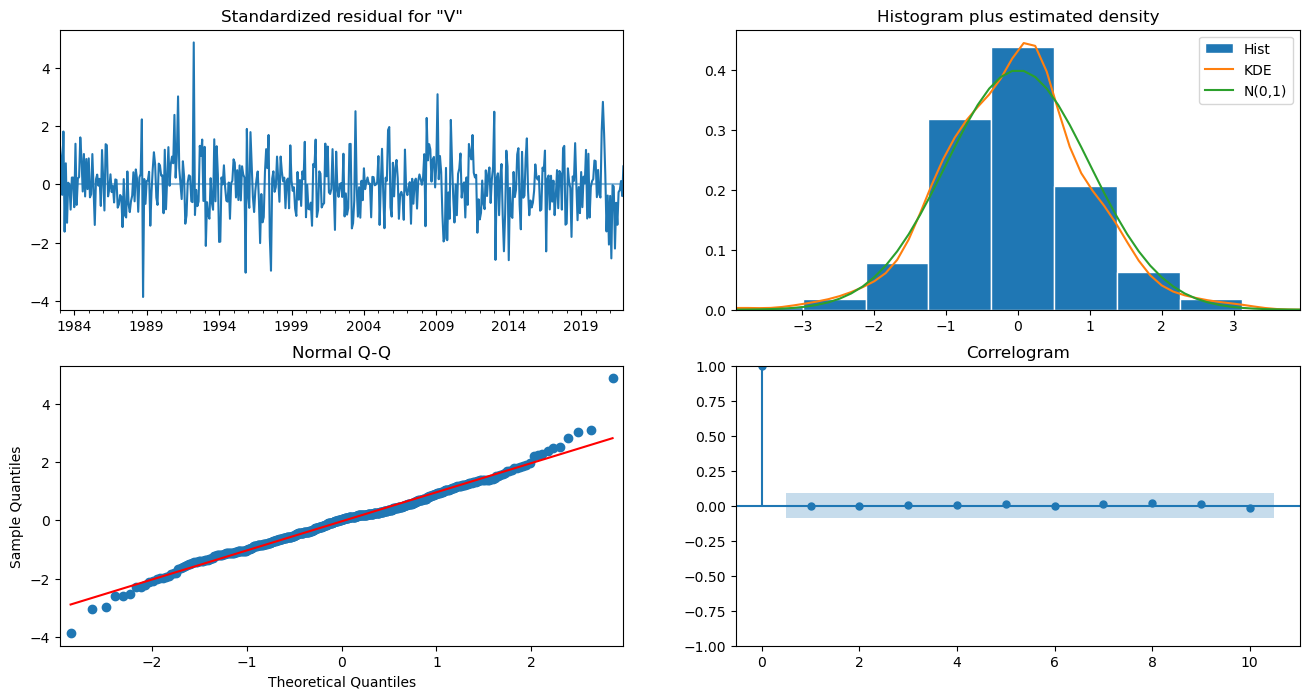

In [14]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#### 2.2.3. Model Results

In [15]:
predictions={}
for date in Y_validation.index:
    pred=results.get_prediction(pd.to_datetime(date))
    predictions[date]=pred.predicted_mean[0]

In [16]:
y_forecasted = np.array(list(predictions.values()))
y_truth = Y_validation.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(sqrt(mse)))

The Root Mean Squared Error of our forecasts is 0.10309288735426501


#### 2.2.4. Training on Full Data and Predicting

In [17]:
mod_full_data = ARIMA(Y_full,order=best_cfg)
results_full_data = mod_full_data.fit()
print(results_full_data.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9679      1.121      6.215      0.000       4.770       9.165
ar.L1          0.6595      0.587      1.123      0.261      -0.491       1.810
ar.L2          0.3466      0.770      0.450      0.653      -1.163       1.856
ar.L3          0.2511      0.293      0.858      0.391      -0.323       0.825
ar.L4         -0.0949      0.105     -0.899      0.369      -0.302       0.112
ar.L5          0.0388      0.070      0.552      0.581      -0.099       0.177
ar.L6         -0.1440      0.088     -1.635      0.102      -0.317       0.029
ar.L7         -0.0568      0.130     -0.437      0.662      -0.312       0.198
ar.L8          0.1369      0.077      1.767      0.077      -0.015       0.289
ar.L9         -0.0524      0.136     -0.385      0.700      -0.319       0.215
ar.L10        -0.0907      0.105     -0.866      0.3

In [18]:
preds_df = (results_full_data
            .get_prediction(start='2023-01-01', end='2023-05-01')
            .summary_frame(alpha=0.05)
)

preds_df

Value,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-01,3.729279,0.091623,3.549701,3.908858
2023-02-01,3.730559,0.142649,3.450973,4.010145
2023-03-01,3.723641,0.195542,3.340387,4.106896
2023-04-01,3.758258,0.245908,3.276287,4.240229
2023-05-01,3.793753,0.295281,3.215012,4.372493
